# Convergence of the mappings

Study the numerical convergence of mappings

In [1]:
%load_ext autoreload
%autoreload 2

In [157]:
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.colors as mplcolors
import numpy as np
from scipy import stats
from neurodyn import *

## Quick test of fast vs naive implementation (sanity check)

In [223]:
def binned_index_connectivity_naive(rnn: LowRankRNN, n: int, bin_index: np.ndarray) -> np.ndarray:
	# a naive implementation to test things out, slow !!
	from tqdm import tqdm
	
	_, bin_index_count = np.unique(bin_index, return_counts=True)
	J = np.zeros((4**n, 4**n), dtype=float)

	for i in tqdm(range(rnn.N)):
		for j in range(rnn.N):
			if i == j: continue
			J[bin_index[i], bin_index[j]] += (rnn.F[i] * rnn.G[j]).sum()

	J /= rnn.N

	for alpha in range(4):
		J[alpha, :] /= bin_index_count[alpha]

	return J


def binned_index_connectivity(rnn: LowRankRNN, n: int, bin_index: np.ndarray) -> np.ndarray:
	from tqdm import tqdm
	from collections import Counter
	# _, bin_index_count = np.unique(bin_index, return_counts=True)
	bin_index_count = Counter(bin_index)
	J = np.zeros((4**n, 4**n), dtype=float)

	for alpha in tqdm(range(4**n)):
		if bin_index_count.get(alpha, 0.0) == 0.0: continue
		for beta in range(4**n):
			J[alpha, beta] += np.einsum('im,jm->', rnn.F[bin_index == alpha, :], rnn.G[bin_index == beta, :])
			if alpha == beta:  # exclude self connections
				J[alpha, beta] -= np.einsum('im,im->', rnn.F[bin_index == alpha, :], rnn.G[bin_index == beta, :])
		# J[alpha, :] /= bin_index_count[alpha]
		J[alpha, :] /= bin_index_count.get(alpha, 0.0)
		
	J /= rnn.N

	return J

In [36]:
rnn = LowRankRNN.new_valentin(p=2, N=1000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
n = 1
mapping = recursive_quadrant_mapping(rnn.F, n)
bin_index = (mapping * 4**n).astype(int)
print(f'{bin_index[:20]=}')

print('-- naive method --')
print(binned_index_connectivity_naive(rnn, n, bin_index))

print('-- fast method --')
print(binned_index_connectivity(rnn, n, bin_index))

bin_index[:20]=array([0, 2, 2, 1, 2, 3, 2, 1, 1, 1, 3, 1, 1, 2, 0, 1, 3, 2, 1, 2])
-- naive method --


100%|██████████| 1000/1000 [00:04<00:00, 236.20it/s]


[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
-- fast method --
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]


## Visualize binning of the $J_{ij}$ matrix

In [203]:
rnn = LowRankRNN.new_valentin(p=2, N=1024, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
n = 4  # 4**n = 4**4 = 256 boxes along each axis
mapping = recursive_quadrant_mapping(rnn.F, n)
bin_index = (mapping * 4**n).astype(int)
from collections import Counter
bin_index_count = Counter(bin_index)

idx_sort = np.argsort(mapping)
J_dense = rnn.params.to_dense().J[idx_sort, :][:, idx_sort]

xx, yy = np.meshgrid(mapping[idx_sort], mapping[idx_sort])
flatcoords = np.vstack((xx.flatten(), yy.flatten())).T  # we need to flatten J in order to interpolate each component on the (alpha, beta) coordinates
J_binned = stats.binned_statistic_2d(
	flatcoords[:, 0], flatcoords[:, 1], J_dense.flat,
	statistic='sum', bins=[np.linspace(0, 1, 4**n+1), np.linspace(0, 1, 4**n+1)],
).statistic

J_rescaled = J_binned.copy()
J_rescaled = np.nan_to_num(J_rescaled, nan=0.0)
for alpha in range(4**n):
	if bin_index_count.get(alpha, 0.0) == 0.0: continue
	J_rescaled[alpha, :] /= bin_index_count.get(alpha, 0.0)
# J_rescaled /= rnn.N  # we don't need to rescale by N, because J is already divided by N

J_ab = binned_index_connectivity(rnn, n, bin_index)

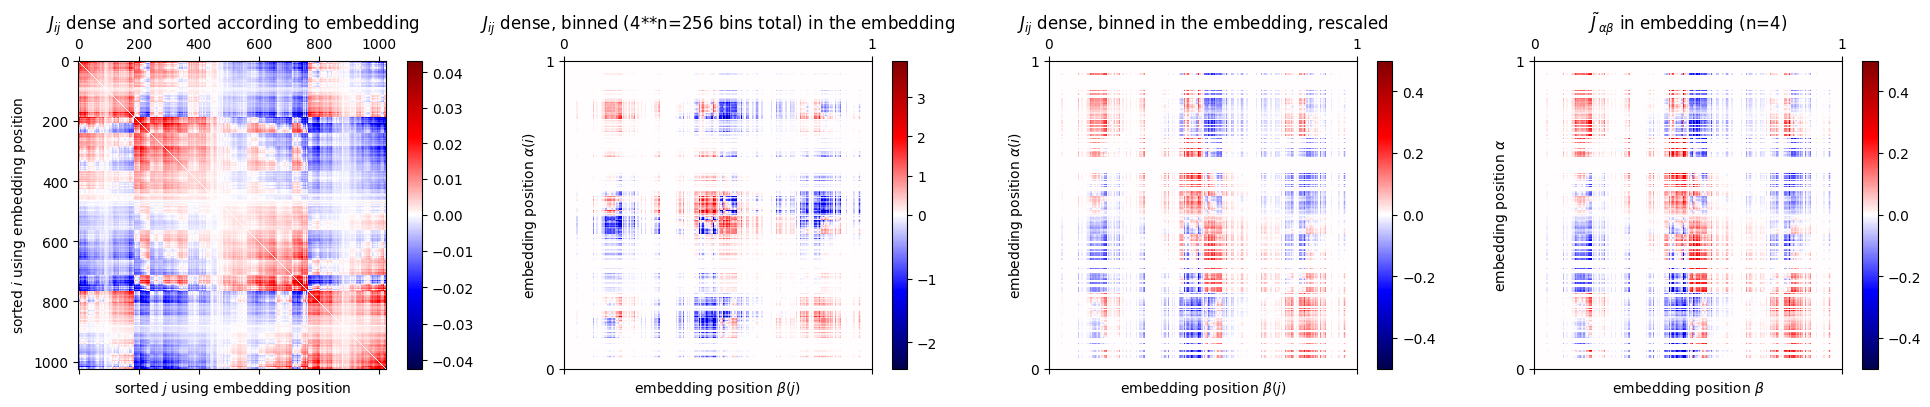

In [199]:
fig, axes = plt.subplots(figsize=(24, 4), ncols=4)

axes[0].set_title('$J_{ij}$ dense and sorted according to embedding')
axes[0].set_xlabel('sorted $j$ using embedding position')
axes[0].set_ylabel('sorted $i$ using embedding position')
axes[1].set_title(f'$J_{{ij}}$ dense, binned ({4**n=} bins total) in the embedding')
axes[1].set_xlabel('embedding position $\\beta(j)$')
axes[1].set_ylabel('embedding position $\\alpha(i)$')
axes[2].set_title('$J_{ij}$ dense, binned in the embedding, rescaled')
axes[2].set_xlabel('embedding position $\\beta(j)$')
axes[2].set_ylabel('embedding position $\\alpha(i)$')
axes[3].set_title(f'$\\tilde J_{{\\alpha\\beta}}$ in embedding (n={n})')
axes[3].set_xlabel('embedding position $\\beta$')
axes[3].set_ylabel('embedding position $\\alpha$')

im = axes[0].matshow(J_dense, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
fig.colorbar(im, ax=axes[0])

im = axes[1].matshow(J_binned, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[1])

im = axes[2].matshow(J_rescaled, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0, vmin=-0.5, vmax=0.5), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[2])

im = axes[3].matshow(J_ab, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0, vmin=-0.5, vmax=0.5), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[3])

plt.show()

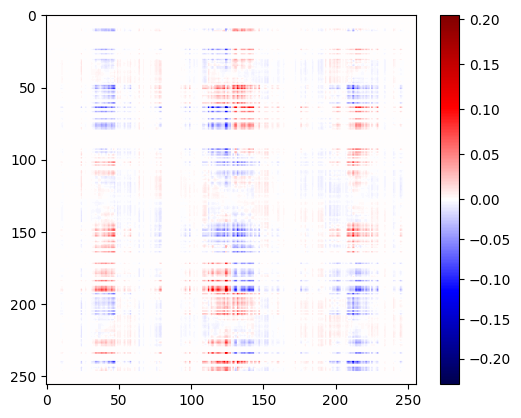

In [202]:
# TODO : why do we still see some difference ? Are these just numerical inaccuracies ?
plt.imshow(J_rescaled - J_ab, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
plt.colorbar();

## Simulate convergence

simulating LowRankRNN{N=20000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:02<00:00]


LowRankRNN{N=20000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}


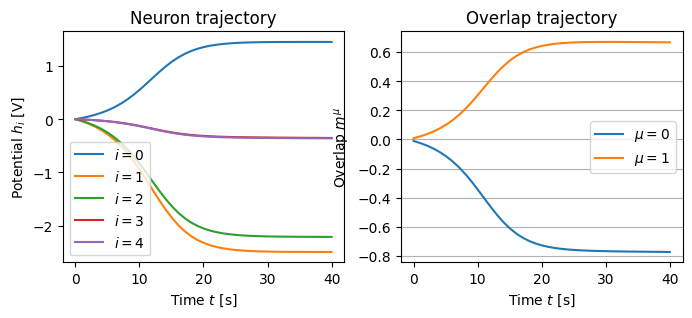

In [247]:
rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
# res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 40), dt_max=0.5, progress=True)  # TODO : how do we adapt the mu patterns to the embedding ?
res = rnn.simulate(h0=np.zeros(rnn.N), t_span=(0, 40), dt_max=1, progress=True)
print(rnn)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
plot_neuron_trajectory(res, figax=(fig, axes[0]));
plot_overlap_trajectory(rnn, res, figax=(fig, axes[1]));

In [253]:
n = 4  # 4**n = 4**4 = 256 boxes along each axis
mapping = recursive_quadrant_mapping(rnn.F, n)
bin_index = (mapping * 4**n).astype(int)
J = binned_index_connectivity(rnn, n, bin_index)

100%|██████████| 256/256 [00:20<00:00, 12.69it/s]


In [254]:
rnn_dense = DenseRNN(DenseRNNParams(phi=rnn.phi, I_ext=rnn.I_ext, exclude_self_connections=rnn.exclude_self_connections, J=J))
print(rnn_dense)

DenseRNN{N=256, phi=sigmoid, I_ext=zero, exclude_self_connections=True}


In [255]:
res_dense = rnn_dense.simulate(h0=np.zeros(rnn_dense.N), t_span=(0, 40), dt_max=1, progress=True)

simulating DenseRNN{N=256, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 0.00%|          | t=0.000 of 40 [00:00<?]


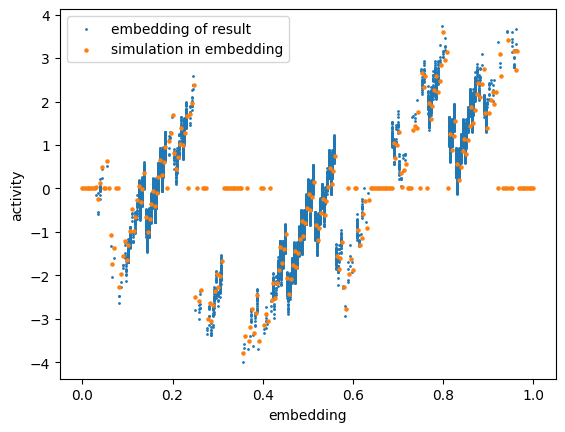

In [256]:
fig, ax = plt.subplots()
ax.scatter(mapping, res.h[:, -1], s=1, label='embedding of result')
ax.scatter(np.linspace(0, 1, 4**n), res_dense.h[:, -1], s=5, label='simulation in embedding')
ax.legend()
ax.set_xlabel('embedding')
ax.set_ylabel('activity')
plt.show()

In [216]:
# TODO : how do we compute overlap on the embedded RNN ?

In [ ]:
# TODO : run with more neurons